In [3]:
import numpy as np
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt

# iPython magic command for inline figures. If this command is not given, figures are generated in windows.
# An asterisk appears in the cell prompt (i.e. "In [*]:"), and the kernel stalls until the window is closed.
%matplotlib inline

## Below are two simple examples of exception handling

## Try to import pandas. If not existent, set flag = False, and raise an exception.
try:
    import pandas as pd
    pd_flag = True
except ImportError:
    print("Package pandas not found. Cannot do funky data structures!")
    pd_flag = False
    
## Try to import seaborn.
try:
    import seaborn as sns
    sns_flag = True
    sns.set_style("whitegrid")
    sns.set_style("ticks")
except ImportError:
    sns_flag = False
print("Does seaborn exist on the computer? " + str(sns_flag))

Does seaborn exist on the computer? True


## Maximum likelihood estimation with confidence intervals on the MLEs

We will now consider an example of how to fit data to obtain MLEs for the fit parameters, and also produce confidence intervals on those MLEs.  To start with we will set up this notebook with some of the useful functions which we used in Week 4:

In [4]:
### Import the scipy optimisation package
import scipy.optimize as op

###
### The two forms of the likelihood - note that the function LogLikelihood assumes normally distributed errors
###CHECK IF NORMALLY DISTRiBUTED ERROR BARS>>> IF TRUE >>> USE CURVE FIT

def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    ymod = my_model(xval, parm)  #We define our 'physical model' separately
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    return -sum(np.log(nd.pdf(yval)))

def ChiSq(parm, xval, yval, dy): # the weighted least-squares
    ymod = my_model(xval, parm)
    chisq = sum(pow((yval-ymod)/dy,2))
    return chisq

###
### And to convert significances from sigma to p and vice versa
###

def sigmas_to_p(sigval):
    nd = scipy.stats.norm(0., 1.)
    return 2.*nd.sf(sigval)

def p_to_sigmas(pval):
    nd = scipy.stats.norm(0., 1.)
# We use the 'inverse survival function', the inverse of the sf. We also need to divide
# our p-value by 2 to account for the negative side of the normal distribution.
    return nd.isf(pval/2.)

For this example we will use the linear part of the Reynolds fluid flow data which we used to demonstrate maximum likelihood estimation with a 2-parameter linear model in Week 4.  We will first set up the model and fit using weighted-least-squares and Nelder-Mead minimisation as in Week 4, producing as output the MLEs, chi-squared, degrees-of-freedom and also the goodness of fit:

In [6]:
reynolds = np.genfromtxt ("reynolds.txt", dtype=np.float, names=["dP", "v"], skip_header=1, autostrip=True)
## change units
ppm = 9.80665e3
dp = reynolds["dP"]*ppm
v = reynolds["v"]
## Now select the first 8 pairs of values, where the flow is laminar,
## and assign to x and y
xval = dp[0:8]
yval = v[0:8]
dy = 6.3e-3  ## We will assume a constant error for the purposes of this exercise

# parm is the vector of parameters, a (parm[0]) and b (parm[1])
def my_model(value, parm):
    return parm[0] + parm[1]*value

# First set the starting values of model parameters.  You should make sure
# these aren’t way off the expected values or the optimisation may get stuck
# - this doesn’t mean you need to know the values already, just choose something
# that seems plausible given the data.
parm = [0.01, 0.0035]
# Now the optimisation function: we can also change the function called to ChiSq
# without changing anything else, since the parameters are the same.
result = op.minimize(ChiSq, parm, args=(xval, yval, dy), method="Nelder-Mead")
a_mle, b_mle = result["x"]
mlval = result["fun"]

# Output the results
dof = len(xval)-len(parm)
print "Weighted least-squares fit results:"
print "Best-fitting intercept = " + str(a_mle) + " and gradient " + str(b_mle) + " with chi-squared = " + str(mlval)
print "for " + str(dof) + " d.o.f.."

# Output the goodness-of-fit
print "The goodness of fit of the linear model is: " + str(scipy.stats.chi2.sf(mlval, df=dof))

Weighted least-squares fit results:
Best-fitting intercept = 0.00751203430537 and gradient 0.00347096171654 with chi-squared = 5.99576886296
for 6 d.o.f..
The goodness of fit of the linear model is: 0.423664224004


### MLE confidence intervals from the covariance matrix: `fmin_bfgs`

We will now examine two approaches to estimate confidence intervals on the MLEs based on the <i>Hessian</i> (or equivalently, the <i>covariance matrix</i>).  In many cases we cannot easily determine the Hessian of our likelihood function analytically,
so the best approach is to do it numerically. Here the choice of optimiser is crucial. Some
optimisers already require knowledge of the Jacobian (or even the Hessian itself!), which we
often don't have. Others do not calculate Jacobians or Hessians at all. The best optimisers for
our purpose are ones which already calculate the first and second derivatives numerically and
so can output the Hessian that we require.  First we will consider the `fmin_bfgs` function.

In scipy's `optimize` package, the Nelder-Mead simplex algorithm is quite robust for minimisation problems but does not use any gradient evaluations so does not return the Hessian. Therefore, we use the `optimize` implementation of the Broyden-Fletcher-
Goldfarb-Shanno algorithm (BFGS) which does use numerical estimates of the gradient. The
`scipy.optimize.fmin_bfgs` minimisation routine does the job for us and even provides the inverse Hessian (i.e. the covariance matrix!) as output. The method can be a bit flakey however,
since it's search of the parameter space sometimes makes large jumps which may lead to infinities in the likelihood function (depending on how it is set up), which can cause the minimisation
process to stop. Therefore we must be careful to set things up so as to optimise our chances of
a good fit.

Let's assume that we have things set up as they were prior to minimisation of the
log-likelihood. Instead of using the `minimize` routine with Nelder-Mead, we will use `fmin_bfgs`
instead:

In [5]:
ml_pars, ml_funcval, ml_grad, ml_covar, func_calls, grad_calls, warnflag = \
scipy.optimize.fmin_bfgs(LogLikelihood, parm, args=(xval, yval, dy), full_output=True)

         Current function value: -28.913645
         Iterations: 0
         Function evaluations: 24
         Gradient evaluations: 3


This call should output the results of our minimisation to the variables given, however as you should notice, the
minimisation fails.

In [6]:
print ml_pars

[ 0.01    0.0035]


Our output parameters tell us that the minimisation has got stuck. To see what is going
wrong we can make our `LogLikelihood` function more verbose:

In [7]:
def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    ymod = my_model(xval, parm)
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    print("nd: " + str(nd.pdf(yval)))
    ll= -sum(np.log(nd.pdf(yval)))
    print("LogLikelihood and parameters "+ str(ll),str(parm))
    return ll

ml_pars, ml_funcval, ml_grad, ml_covar, func_calls, grad_calls, warnflag = \
scipy.optimize.fmin_bfgs(LogLikelihood, parm, args=(xval, yval, dy), full_output=True)

nd: [ 57.12963257  63.32363253   6.09224008  35.91952165  48.46935515
  56.6844252   29.28654317  56.61125031]
('LogLikelihood and parameters -28.9136454097', '[ 0.01    0.0035]')
nd: [ 57.12957126  63.32363314   6.0922089   35.91961212  48.46927132
  56.68436209  29.28645714  56.61118692]
('LogLikelihood and parameters -28.9136348468', '[ 0.01000001  0.0035    ]')
nd: [ 57.12915154  63.32364212   6.09150929  35.9223519   48.4660832
  56.68146682  29.28183587  56.60728374]
('LogLikelihood and parameters -28.9132454564', '[ 0.01        0.00350001]')
nd: [ 57.12963257  63.32363253   6.09224008  35.91952165  48.46935515
  56.6844252   29.28654317  56.61125031]
('LogLikelihood and parameters -28.9136454097', '[ 0.01    0.0035]')
nd: [ 0.  0.  0.  0.  0.  0.  0.  0.]
('LogLikelihood and parameters inf', '[  -708.8541808  -26840.40717314]')
nd: [ 0.  0.  0.  0.  0.  0.  0.  0.]
('LogLikelihood and parameters inf', '[  -708.8541808  -26840.40717314]')
nd: [ 0.  0.  0.  0.  0.  0.  0.  0.]
('L

Now we run `fmin_bfgs` again and we see that the problem arises as the parameters jump to large negative values, leading to zero probabilities (within numerical precision) and hence a problem
with the log-likelihood. One way to fix this is to force the parameters to take on only certain values. E.g. if we instead make the parameters used equal to the logarithm of our parameters $a$ or $b$, we restrict the range of values used for $a$ or $b$ to only be positive.  We can also add some other rules to deal with other exceptions:

In [8]:
parm = np.log([0.01,0.0035])

def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    logmax = 1.e12 # sets a maximum acceptable value for the -ve log-likelihood
    parm_new = np.exp(np.array(parm))
    ymod = my_model(xval, parm_new)
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    ll = -sum(np.log(nd.pdf(yval)))
    if np.isinf(ll) or np.isnan(ll): # This catches our infinities or nans
        print("I am here")
        print("parm: " + str(parm))
        return logmax
    else:
        return ll
    
ml_pars, ml_funcval, ml_grad, ml_covar, func_calls, grad_calls, warnflag = \
scipy.optimize.fmin_bfgs(LogLikelihood, parm, args=(xval, yval, dy), full_output=True)

### To output remember to convert back from log to linear:
print np.exp(ml_pars)

         Current function value: -30.188265
         Iterations: 7
         Function evaluations: 84
         Gradient evaluations: 18
[ 0.00752052  0.0034705 ]


With this redefined log-likelihood the BFGS minimisation is successful (as can be seen by comparing our MLEs with those obtained earlier using the robust Nelder-Mead approach). Note however that if we thought that one or more of our parameters might actually be negative, we might need to try
a different approach. To get the errors (1-sigma confidence intervals) for $\log{\left(a\right)}$ and $\log{\left(b\right)}$ we just need the square roots of the diagonals of the covariance matrix returned by `fmin_bfgs` (which are the variances). We can also convert our errors from the log to linear values with standard propagation of errors i.e. using $y = \exp{\left(x\right)}$ so
that $\Delta{y}=\frac{\mathrm{d}y}{\mathrm{d}x}\Delta{x}=\exp{\left(x\right)}\Delta{x}$.

In [9]:
err = np.sqrt(np.diag(ml_covar))
lin_err = err * np.exp(ml_pars)
print("a = " + str(np.exp(ml_pars[0])) + " +/- " + str(lin_err[0]))
print("b = " + str(np.exp(ml_pars[1])) + " +/- " + str(lin_err[1]))

a = 0.0075205167923 +/- 0.00486845119017
b = 0.00347050360687 +/- 0.000123046171379


The MLEs and their 1-sigma confidence intervals are too high in precision given the size of the errors, so it would be better to round them off following the rule-of-thumb suggested in the Week 1 tutorial, i.e. to 2 s.f. in the error and then the corresponding number of decimal places in the MLE itself.

### MLE confidence intervals from the covariance matrix: `curve_fit`

The `fmin_bfgs` minimiser has the advantage that requires no implicit assumption about how the errors on the data points (i.e. the errors on the $y$-values) are distributed - e.g. are they normal or not?).  In many cases however, the errors on the data <i>are</i> normally distributed and in those situations, not only can we use weighted least-squares for the likelihood statistic, but we can also use more specialised and robust mimimisation methods such as the `curve_fit` function in `scipy.optimize`.  The `curve_fit` routine uses non-linear least-squares to fit a function to data (i.e. it is not restrictied to linear least-square fitting) and if the error bars are provided it will carry out a weighted-least-squares fit, which is what we need to obtain a goodness-of-fit as well as confidence intervals.  As well as returning the best-fitting parameters (the MLEs), `curve_fit` also returns the covariance matrix evaluated at the minimum, which can be used as for `fmin_bfgs` above. 

In [10]:
### We define a new model function here since curve_fit requires parameters to be listed spearately
def my_cfmodel(value, a, b): 
    return a + b*value

p0 = [0.01, 0.0035]  # Define starting values
ml_cfpars, ml_cfcovar = scipy.optimize.curve_fit(my_cfmodel, xval, yval, p0, sigma=dy)
err = np.sqrt(np.diag(ml_cfcovar))

print "a = " + str(ml_cfpars[0]) + " +/- " + str(err[0])
print "b = " + str(ml_cfpars[1]) + " +/- " + str(err[1])

### curve_fit does not return the minimum chi-squared so we must calculate that ourselves for the MLEs
### obtained by the fit, e.g. using our original ChiSq function 
print "Minimum Chi-squared = " + str(ChiSq(ml_cfpars,xval,yval,dy)) + " for " + str(len(xval)-len(p0)) + " d.o.f."

a = 0.00752051424807 +/- 0.00490562168423
b = 0.00347050367447 +/- 0.0001242909418
Minimum Chi-squared = 5.99574356054 for 6 d.o.f.


Again, as above, you should round off the MLEs and errors appropriately when you present the final results!

We can compare the MLEs and errors for `curve_fit` and `fmin_bfgs`, e.g. to check that the transformation used to get a sensible fit with `fmin_bfgs` gives similar errors to `curve_fit`.

### Confidence intervals by brute-force grid search

If we are having trouble finding the MLEs and their confidence intervals through standard minimisation, and there are not too many model parameters to search over, we can find the
confidence intervals by brute-force search over a grid of model parameter values. E.g. to find the 1-sigma error on the log-likelihood which we fitted earlier using the Nelder-Mead method
(i.e. go back to the original version of the log-likelihood with the parameters being linear again):

In [11]:
def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    ymod = my_model(xval, parm)  #We define our 'physical model' separately
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    return -sum(np.log(nd.pdf(yval)))

nvals_a = 100
nvals_b = 100
aval = np.linspace(0.0,0.015, nvals_a)
bval = np.linspace(0.003,0.004,nvals_b)
ll = np.zeros((nvals_a,nvals_b))
llmin = 1.e12

# First calculate -ve log-likelihoods and find the corresponding MLEs for a and b:
for i in range(nvals_a-1): ## x dimension
    for j in range(nvals_b-1): ## y dimension
        ll[i,j] = LogLikelihood([aval[i], bval[j]], xval, yval, dy)
        if ll[i,j] < llmin:
            llmin = ll[i,j]
            amin = aval[i]
            bmin = bval[j]

# Now search for the values of a and b which are within 0.5 of the minimum -ve
# log-likelihood while maximising the difference from the MLEs. These should
# correspond to the 1-sigma errors on each MLE.
a_cimin = 1.e12
a_cimax = -1.e12
b_cimin = 1.e12
b_cimax = -1.e12
for i in range(nvals_a-1): ## x dimension
    for j in range(nvals_b-1): ## y dimension
        if ll[i,j]-llmin <= 0.5:
            if aval[i] < amin and aval[i] < a_cimin:
                a_cimin = aval[i]
            if aval[i] > amin and aval[i] > a_cimax:
                a_cimax = aval[i]
            if bval[i] < bmin and bval[i] < b_cimin:
                b_cimin = bval[i]
            if bval[i] > bmin and bval[i] > b_cimax:
                b_cimax = bval[i]
print "Confidence interval for a: ",a_cimin," - ",a_cimax
print "Confidence interval for b: ",b_cimin," - ",b_cimax

print("a = " + str(amin) + " + " + str(a_cimax - amin) + "/- " + str(amin - a_cimin))
print("b = " + str(bmin) + " + " + str(b_cimax - bmin) + "/- " + str(bmin - b_cimin))

Confidence interval for a:  0.00272727272727  -  0.0122727272727
Confidence interval for b:  0.00318181818182  -  0.00381818181818
a = 0.00742424242424 + 0.00484848484848/- 0.00469696969697
b = 0.00347474747475 + 0.000343434343434/- 0.000292929292929


The values obtained from the brute force grid-search method are similar to those obtained from the Hessian. Note however that the grid search allows us to assign different errors in different directions where it is appropriate. Of course, one could also use a similar approach using weighted least-squares (except the difference in $X^2$ used for a given error bar is different, e.g. $\Delta{X^2} = 1$ for 1-sigma confidence intervals.

For bivariate data, especially when the errors in MLEs are covariant, it is often useful to plot
*confidence contours* showing contours of constant confidence on an MLE (i.e. contours of the
likelihood surface).

[ 0.003       0.0030101   0.0030202   0.0030303   0.0030404   0.00305051
  0.00306061  0.00307071  0.00308081  0.00309091  0.00310101  0.00311111
  0.00312121  0.00313131  0.00314141  0.00315152  0.00316162  0.00317172
  0.00318182  0.00319192  0.00320202  0.00321212  0.00322222  0.00323232
  0.00324242  0.00325253  0.00326263  0.00327273  0.00328283  0.00329293
  0.00330303  0.00331313  0.00332323  0.00333333  0.00334343  0.00335354
  0.00336364  0.00337374  0.00338384  0.00339394  0.00340404  0.00341414
  0.00342424  0.00343434  0.00344444  0.00345455  0.00346465  0.00347475
  0.00348485  0.00349495  0.00350505  0.00351515  0.00352525  0.00353535
  0.00354545  0.00355556  0.00356566  0.00357576  0.00358586  0.00359596
  0.00360606  0.00361616  0.00362626  0.00363636  0.00364646  0.00365657
  0.00366667  0.00367677  0.00368687  0.00369697  0.00370707  0.00371717
  0.00372727  0.00373737  0.00374747  0.00375758  0.00376768  0.00377778
  0.00378788  0.00379798  0.00380808  0.00381818  0

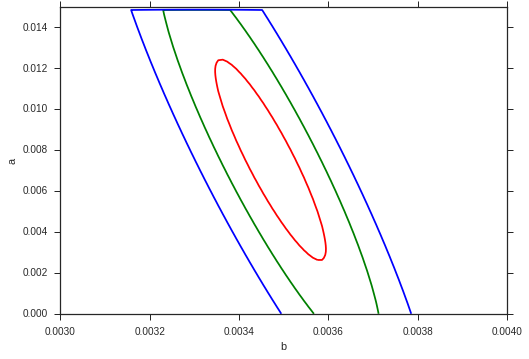

In [12]:
# First we assign all three variables to their own 2D arrays:
print bval
X, Y = np.meshgrid(bval,aval)
#Z = np.exp(-ll)
Z = ll
levels = [llmin+0.5, llmin+2.0, llmin+4.5] # plots the 1, 2 and 3-sigma

# confidence contours
plt.figure()
ax = plt.contour(X, Y, Z, levels, colors = ('r', 'g', 'b'))
plt.xlabel('b')
plt.ylabel('a')
plt.show()

## A complete example: the Pedroni et al. pion scattering data from Vaughan

We will now run through a complete example of ML fitting using the Pedroni et al. pion scattering data from the Vaughan book.  The data is contained in the file `pedroni.dat`.  Important background information is in Appendix B.5 of the book, which is also scanned as a pdf available with this tutorial. 

In [70]:
#  First let's read in the data.  Use np.genfromtxt which can deal with NANs
pion = np.genfromtxt("pedroni.dat", dtype=np.float, skip_header=1, 
autostrip=True)
# and only include values for energies up to 313 MeV, as recommended
# in the book and by Pedroni et al.
pion_clean = pion[pion[:,0] <= 313.0]
xval = pion_clean[:,0]
yval = pion_clean[:,1]
dy = pion_clean[:,2]

Now from this point we need to define the (Breit-Wigner) model and proceed to fit it to the data to find the MLEs and their 1-sigma confidence intervals, as well as the goodness of fit of the model.  At the end, you should plot the data and model together, along with the data-minus-model residuals in a separate plot.

a = 110.22703941 +/- 0.37736778041
b = 175.820915231 +/- 0.180325178623
c = 205.022251608 +/- 0.525305370821
Minimum Chi-squared = 38.012956708 for 33 d.o.f.


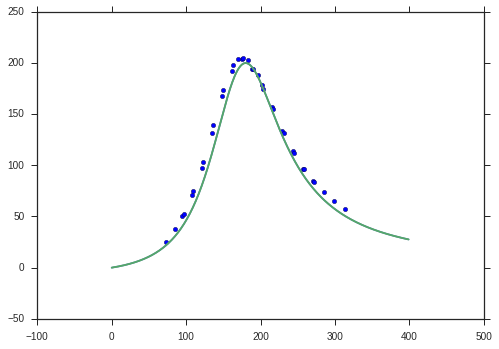

In [79]:
def Breit_Wigner(value,a,b,c):
    gam = a*(value/130.)**(1./2.)
#     print a,b,c
    return (c*((gam**2.)/4))/((value-b)**2 + ((gam**2.)/4.))

p0 = [100,180,200]
x= np.arange(0,400,1)
ymod = Breit_Wigner(x,p0[0],p0[1],p0[2])
plt.plot(x,ymod)
plt.show


def ChiSq(parm, xval, yval, dy): # the weighted least-squares
    ymod = Breit_Wigner(xval, parm[0],parm[1],parm[2])
    chisq = sum(pow((yval-ymod)/dy,2))
    return chisq

xval = eval
yval = cross
dy = crosserr

  # Define starting values
ml_cfpars, ml_cfcovar = scipy.optimize.curve_fit(Breit_Wigner, xval, yval, p0, sigma=dy)
err = np.sqrt(np.diag(ml_cfcovar))

print "a = " + str(ml_cfpars[0]) + " +/- " + str(err[0])
print "b = " + str(ml_cfpars[1]) + " +/- " + str(err[1])
print "c = " + str(ml_cfpars[2]) + " +/- " + str(err[2])

### curve_fit does not return the minimum chi-squared so we must calculate that ourselves for the MLEs
### obtained by the fit, e.g. using our original ChiSq function 
print "Minimum Chi-squared = " + str(ChiSq(ml_cfpars,xval,yval,dy)) + " for " + str(len(xval)-len(p0)) + " d.o.f."


plt.plot(x,ymod)
plt.scatter(eval,cross)
plt.show()


## Dealing with binned data

So far we have been dealing with data where the $x$ and $y$ values are already defined, along with the errors on the $y$ values (such that we have generally assumed the errors to be normally distributed).  However, many types of data are in the form of <i>counts</i> which must be binned (i.e. into histograms) so that models may be fitted to the distribution of counts with whatever their values are (e.g. energy, if the counts are photons or other particles drawn from a continuous distribution of energies which are observed by some type of spectrometer).  How do we deal with this data?  How do we fit models to it? Here we will start with a simple list of photon energies and go from there...

In [13]:
photens = np.genfromtxt('photon_energies.txt')